In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score,precision_recall_curve, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
ddos=pd.read_csv("ddos_dataset.csv")

In [3]:
ddos

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,172.31.69.28-18.216.200.189-80-52169-6,22/02/2018 12:27:57 AM,233.750000,233.750000,-1,32768,0,ddos
1,172.31.69.25-18.219.193.20-80-44588-6,16/02/2018 11:18:14 PM,0.000000,0.000000,-1,225,0,ddos
2,172.31.69.25-18.219.193.20-80-43832-6,16/02/2018 11:23:20 PM,114.333333,114.333333,-1,219,0,ddos
3,172.31.69.25-18.219.193.20-80-53346-6,16/02/2018 11:22:41 PM,233.750000,233.750000,-1,211,0,ddos
4,172.31.69.28-18.218.55.126-80-57856-6,21/02/2018 11:49:25 PM,233.750000,233.750000,-1,32768,0,ddos
...,...,...,...,...,...,...,...,...
499995,172.31.0.2-172.31.67.64-53-59559-17,20/02/2018 02:07:36,40.000000,40.000000,-1,-1,8,Benign
499996,172.31.66.109-23.196.115.33-49812-80-6,20/02/2018 08:38:20,318.000000,318.000000,8192,1024,20,Benign
499997,151.101.34.109-172.31.64.29-443-53701-6,20/02/2018 04:36:27,56.555556,56.555556,8192,60,20,Benign
499998,172.31.0.2-172.31.65.44-53-60384-17,20/02/2018 08:28:46,40.000000,40.000000,-1,-1,8,Benign


In [4]:
ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow ID            500000 non-null  object 
 1   Timestamp          500000 non-null  object 
 2   Fwd Pkt Len Mean   500000 non-null  float64
 3   Fwd Seg Size Avg   500000 non-null  float64
 4   Init Fwd Win Byts  500000 non-null  int64  
 5   Init Bwd Win Byts  500000 non-null  int64  
 6   Fwd Seg Size Min   500000 non-null  int64  
 7   Label              500000 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 30.5+ MB


In [5]:
ddos.isna().sum()

Flow ID              0
Timestamp            0
Fwd Pkt Len Mean     0
Fwd Seg Size Avg     0
Init Fwd Win Byts    0
Init Bwd Win Byts    0
Fwd Seg Size Min     0
Label                0
dtype: int64

In [6]:
ddos.duplicated().sum()

437

In [7]:
ddos.groupby('Label').size()

Label
Benign    400000
ddos      100000
dtype: int64

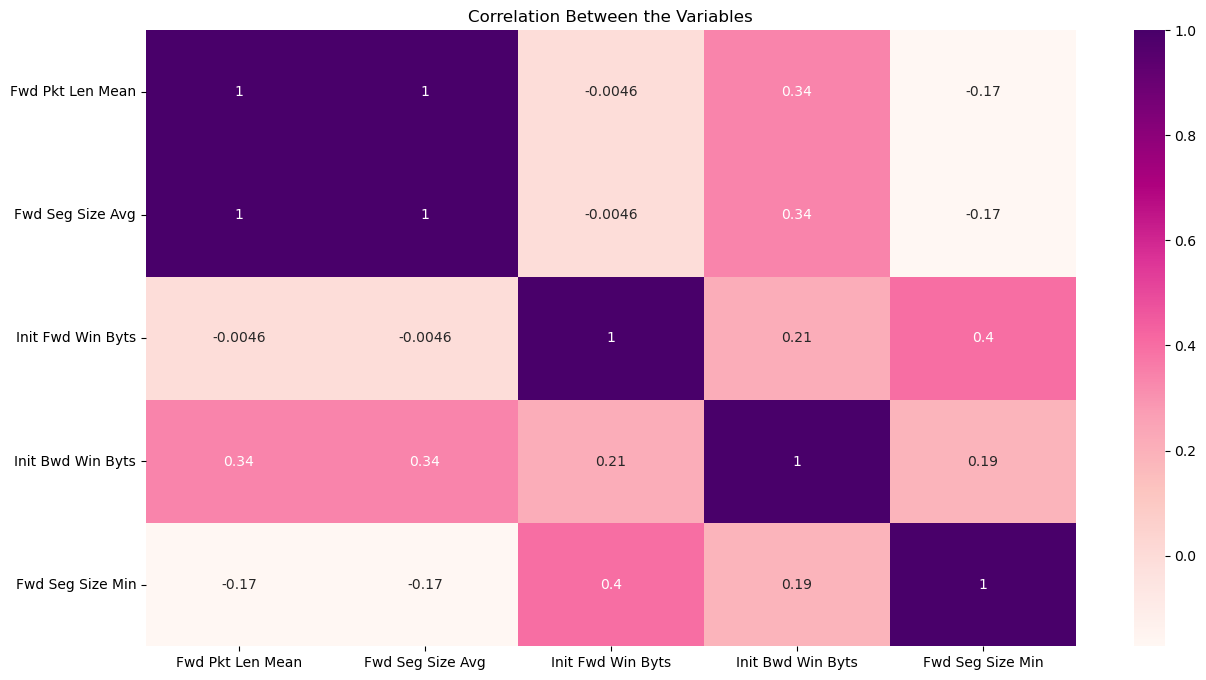

In [8]:
numeric_data = ddos.select_dtypes(include='number')# select only the columns in the DataFrame data that have numeric (number) data
correlation_matrix = numeric_data.corr()
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(correlation_matrix, annot=True,ax=ax, cmap="RdPu")
plt.title('Correlation Between the Variables')
#plt.xticks(rotation=45);
plt.show()

In [9]:
columns_to_drop = ['tcp.dstport', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.reset', 'tcp.flags.ack', 'ip.flags.mf', 'ip.flags.rb', 'tcp.seq', 'tcp.ack']
ddos_new = ddos.drop(columns=columns_to_drop, errors='ignore').copy()
ddos_new

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,172.31.69.28-18.216.200.189-80-52169-6,22/02/2018 12:27:57 AM,233.750000,233.750000,-1,32768,0,ddos
1,172.31.69.25-18.219.193.20-80-44588-6,16/02/2018 11:18:14 PM,0.000000,0.000000,-1,225,0,ddos
2,172.31.69.25-18.219.193.20-80-43832-6,16/02/2018 11:23:20 PM,114.333333,114.333333,-1,219,0,ddos
3,172.31.69.25-18.219.193.20-80-53346-6,16/02/2018 11:22:41 PM,233.750000,233.750000,-1,211,0,ddos
4,172.31.69.28-18.218.55.126-80-57856-6,21/02/2018 11:49:25 PM,233.750000,233.750000,-1,32768,0,ddos
...,...,...,...,...,...,...,...,...
499995,172.31.0.2-172.31.67.64-53-59559-17,20/02/2018 02:07:36,40.000000,40.000000,-1,-1,8,Benign
499996,172.31.66.109-23.196.115.33-49812-80-6,20/02/2018 08:38:20,318.000000,318.000000,8192,1024,20,Benign
499997,151.101.34.109-172.31.64.29-443-53701-6,20/02/2018 04:36:27,56.555556,56.555556,8192,60,20,Benign
499998,172.31.0.2-172.31.65.44-53-60384-17,20/02/2018 08:28:46,40.000000,40.000000,-1,-1,8,Benign


In [10]:
ddos_new = ddos_new.drop(columns=['frame.time'], errors='ignore')
ddos_new

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,172.31.69.28-18.216.200.189-80-52169-6,22/02/2018 12:27:57 AM,233.750000,233.750000,-1,32768,0,ddos
1,172.31.69.25-18.219.193.20-80-44588-6,16/02/2018 11:18:14 PM,0.000000,0.000000,-1,225,0,ddos
2,172.31.69.25-18.219.193.20-80-43832-6,16/02/2018 11:23:20 PM,114.333333,114.333333,-1,219,0,ddos
3,172.31.69.25-18.219.193.20-80-53346-6,16/02/2018 11:22:41 PM,233.750000,233.750000,-1,211,0,ddos
4,172.31.69.28-18.218.55.126-80-57856-6,21/02/2018 11:49:25 PM,233.750000,233.750000,-1,32768,0,ddos
...,...,...,...,...,...,...,...,...
499995,172.31.0.2-172.31.67.64-53-59559-17,20/02/2018 02:07:36,40.000000,40.000000,-1,-1,8,Benign
499996,172.31.66.109-23.196.115.33-49812-80-6,20/02/2018 08:38:20,318.000000,318.000000,8192,1024,20,Benign
499997,151.101.34.109-172.31.64.29-443-53701-6,20/02/2018 04:36:27,56.555556,56.555556,8192,60,20,Benign
499998,172.31.0.2-172.31.65.44-53-60384-17,20/02/2018 08:28:46,40.000000,40.000000,-1,-1,8,Benign


In [11]:
# Assuming your DataFrame is named df
ddos_new['Label_new'] = ddos_new['Label'].apply(lambda x: 'Benign' if x =='Benign' else 'DDoS')
ddos_new.drop(columns=['Label'], inplace=True)
ddos_new.rename(columns={'Label_new': 'Label'}, inplace=True)
ddos_new

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,172.31.69.28-18.216.200.189-80-52169-6,22/02/2018 12:27:57 AM,233.750000,233.750000,-1,32768,0,DDoS
1,172.31.69.25-18.219.193.20-80-44588-6,16/02/2018 11:18:14 PM,0.000000,0.000000,-1,225,0,DDoS
2,172.31.69.25-18.219.193.20-80-43832-6,16/02/2018 11:23:20 PM,114.333333,114.333333,-1,219,0,DDoS
3,172.31.69.25-18.219.193.20-80-53346-6,16/02/2018 11:22:41 PM,233.750000,233.750000,-1,211,0,DDoS
4,172.31.69.28-18.218.55.126-80-57856-6,21/02/2018 11:49:25 PM,233.750000,233.750000,-1,32768,0,DDoS
...,...,...,...,...,...,...,...,...
499995,172.31.0.2-172.31.67.64-53-59559-17,20/02/2018 02:07:36,40.000000,40.000000,-1,-1,8,Benign
499996,172.31.66.109-23.196.115.33-49812-80-6,20/02/2018 08:38:20,318.000000,318.000000,8192,1024,20,Benign
499997,151.101.34.109-172.31.64.29-443-53701-6,20/02/2018 04:36:27,56.555556,56.555556,8192,60,20,Benign
499998,172.31.0.2-172.31.65.44-53-60384-17,20/02/2018 08:28:46,40.000000,40.000000,-1,-1,8,Benign


In [12]:
y = ddos_new['Label']
y

0           DDoS
1           DDoS
2           DDoS
3           DDoS
4           DDoS
           ...  
499995    Benign
499996    Benign
499997    Benign
499998    Benign
499999    Benign
Name: Label, Length: 500000, dtype: object

In [17]:
x = ddos_new['Label']

In [22]:
x

0           DDoS
1           DDoS
2           DDoS
3           DDoS
4           DDoS
           ...  
499995    Benign
499996    Benign
499997    Benign
499998    Benign
499999    Benign
Name: Label, Length: 500000, dtype: object

In [23]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [24]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)# Split the data into training and testing sets

In [27]:
X_train

269056    Benign
499174    Benign
85143       DDoS
260335    Benign
338124    Benign
           ...  
259178    Benign
365838    Benign
131932    Benign
146867    Benign
121958    Benign
Name: Label, Length: 400000, dtype: object

In [28]:
y_train

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [29]:
class_counts = np.bincount(y_train)
print(f'Count for class 0 (Benign): {class_counts[0]}')
print(f'Count for class 1 (DDoS): {class_counts[1]}')

Count for class 0 (Benign): 320030
Count for class 1 (DDoS): 79970


In [30]:
X_train

269056    Benign
499174    Benign
85143       DDoS
260335    Benign
338124    Benign
           ...  
259178    Benign
365838    Benign
131932    Benign
146867    Benign
121958    Benign
Name: Label, Length: 400000, dtype: object

In [31]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print(f"Decision Tree Accuracy: {accuracy_decision_tree * 100:.2f}%")

ValueError: could not convert string to float: 'Benign'

In [ ]:
cm = confusion_matrix(y_test, y_pred_decision_tree)
class_labels = ["Benign", "DDoS"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)# predict
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Plot precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
precision, recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
area = auc(recall, precision)
()
# Plot F1 score
fig, ax = plt.subplots(figsize=(8, 8))
f1 = 2 * (precision * recall) / (precision + recall)
plt.plot(recall, f1, label='F1 Score')
plt.xlabel('Recall')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
plot_importance(xgb_model)
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
class_labels = ["Benign", "DDoS"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
 y_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()